In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
from pathlib import Path
import numpy as np

import torch

from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch
from turboflow.fast_test import main, test

import matplotlib.pyplot as plt

In [3]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [4]:
seed = 42
hparams = {
    'name':'RFFCNN',
    'do_time' : True,
    'do_cnn' : False,
    'mlp_layers_num': 6,
    'mlp_layers_dim': 256, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 256, 
    'rff_scale_space': 10,
    'rff_num_time': 128, 
    'rff_scale_time': 10,
    'do_divfree': False,
    'lam_sdiv': 0,     # spatial grad(u,v) = torch.autograd(u,v)
    'lam_sfn':  0,     # offgrid L2 reg. on Sfun
    'lam_spec': 0,     # L2 diff on the spectrum
    'lam_grads':0,     # offrgid L2 reg. on grad and autograd
    'lam_curl' :0,     # smooth grad of vorticity
    'lam_pde' : 0,
    'lam_weight': 1e-5,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

path_to_checkpoint = Path('/home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/')
n_epochs = 100

## Training the model

In [5]:
model, best_model_path = main(hparams, seed, n_epochs)
print(best_model_path.split('/')[-1])

Global seed set to 42
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([32768, 3]) torch.Size([32768, 2]) 32 (32, 32, 32, 3)
torch.Size([32768, 3]) torch.Size([32768, 2]) 32 (32, 32, 32, 3)
plDivFreeRFFNet(
  (rff_time): Fourier()
  (rff_space): Fourier()
  (mlp_x): MLP(
    (network): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): Tanh()
    )
  )
  (mlp_t): MLP(
    (network): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): Tanh()
    )
  )
  (mlp_xt): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): Tanh()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
      (3): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
      (4): Sequential(

2022-03-08 12:36:27.370598: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

  | Name      | Type            | Params
----------------------------------------------
0 | rff_time  | Fourier         | 128   
1 | rff_space | Fourier         | 512   
2 | mlp_x     | MLP             | 65.7 K
3 | mlp_t     | MLP             | 32.9 K
4 | mlp_xt    | MLP             | 312 K 
5 | mlp       | MLP             | 130   
6 | sp_grad   | SpatialGradient | 0     
7 | sp_lapl   | Laplacian       | 0     
----------------------------------------------
411 K     Trainable params
640       Non-trainable params
411 K     Total params
1.648     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Path to best model /home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/Turb2D-RFFCNN-epoch=79-val_loss=0.00.ckpt
Garbage collector: collected 73381 objects.
Turb2D-RFFCNN-epoch=79-val_loss=0.00.ckpt


## Testing the model
### Space resolution

Garbage collector: collected 0 objects.


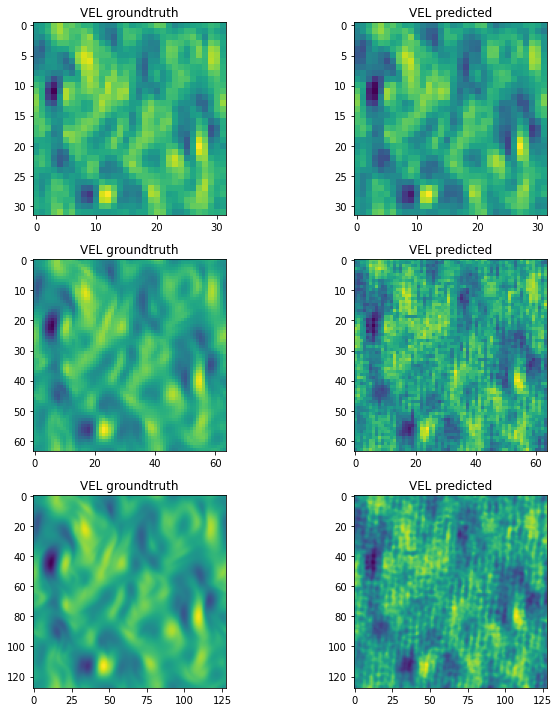

In [6]:
res_space = test(model, dx_train=8, dx_val=4, dx_test=2, n_time=3, batch_size=32)

fig, axarr = plt.subplots(3, 2, figsize=(10,10))

for s, stage in enumerate(res_space.keys()):
    
    uv_true = res_space[stage]['uv_true']
    uv_estm = res_space[stage]['uv_estm']

    t = 1
    axarr[s,0].set_title('VEL groundtruth')
    axarr[s,0].imshow(uv_true[t,:,:,0])
    
    axarr[s,1].set_title('VEL predicted')
    axarr[s,1].imshow(uv_estm[t,:,:,0])

plt.tight_layout()
plt.show()

### Time resolution

Garbage collector: collected 62 objects.


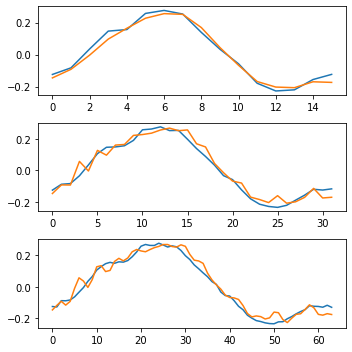

In [7]:
res_time  = test(model, dt_train=4, dt_val=2, 
                 dt_test=1, n_time=16, batch_size=20)

fig, axarr = plt.subplots(3,1, figsize=(5,5))
for s, stage in enumerate(res_time.keys()):
    
    uv_true = res_time[stage]['uv_true']
    uv_estm = res_time[stage]['uv_estm']

    i = 12
    j = 21
    
    axarr[s].plot(uv_true[:,i,j,0], label='VEL groundtruth')
    axarr[s].plot(uv_estm[:,i,j,0], label='VEL predicted')

plt.tight_layout()
plt.show()

In [ ]:
import gc
gc.collect()

In [ ]:
import sys
import pandas as pd

def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    
    memory_usage_by_variable=memory_usage_by_variable.T
    
    memory_usage_by_variable=memory_usage_by_variable\
        .sort_values(by='Size',ascending=False).head(10)
    
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size']\
        .apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

memory_usage()